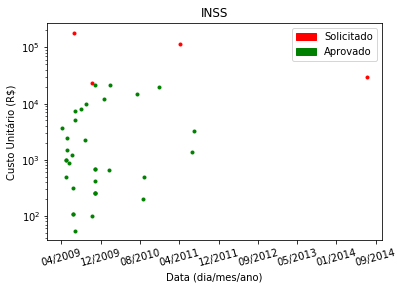

In [142]:
# %load find_outliers.py
from csver import CSVer
from IPython.display import display
from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches


pd.options.mode.chained_assignment = None

class FindOutliers:

    def __init__(self, training_data):
        self.training_data = training_data

    def train_1d(self):
        self.lof = LocalOutlierFactor()
      
        data_1d = self.training_data.reshape(-1, 1)
        self.lof_labels = self.lof.fit_predict(data_1d)
        return self.lof_labels
    
    def train(self):
        if self.is_data_1d():
            return self.train_1d()
        self.lof = LocalOutlierFactor()
    
    def is_data_1d(self):
        dimension = self.training_data.ndim
        return dimension == 1
    
    def plot_inliers_outliers_1d(self, data, labels):
        inliers = data[labels == 1]
        outliers = data[labels == -1]
        
        plt.plot(inliers, np.zeros_like(inliers), alpha = .25,
                 color='green')
        plt.plot(outliers, np.zeros_like(outliers), alpha = .25,
                 color='red')
        plt.show()
        
    def get_xy(self, data):
        return (data['Data'].values,
                data['ValorUnitarioAprovado'].values)
        
    def plot_inliers_outliers(self, data, labels):
        if self.is_data_1d():
            return self.plot_inliers_outliers_1d(data, labels)
        
        inliers = data[labels == 1]
        outliers = data[labels == -1]
        
        x1, y1 = self.get_xy(outliers)
        x2, y2 = self.get_xy(inliers)

        fig = plt.figure()
        plotter = Plotter()

        red_patch = mpatches.Patch(color='red', label='Solicitado')
        green_patch = mpatches.Patch(color='green', label='Aprovado')
        plt.legend(handles=[red_patch, green_patch])

        plotter.plot_log_along_time(x1, y1, '.r', figure=fig)
        plotter.plot_log_along_time(x2, y2, '.g', 'Data (dia/mes/ano)',
                                    'Custo Unitário (R$)', item,
                                    figure=fig)
        plotter.show()
    
    def find_outliers_by_price(self, item):
        dt_item = csver.filter_column_by_value('Item', item)    
        prices = dt_item['ValorUnitarioAprovado'].values
    
        find_outliers = FindOutliers(prices)
        pred = find_outliers.train()
        return (prices, pred)
    
    def find_outliers_price_data(self, data):
        xy = data[['Data', 'ValorUnitarioAprovado']]
        xy['Data'] = CSVer.get_date_axis_from_array(None, xy.Data)
        
        lof = LocalOutlierFactor()
        labels = lof.fit_predict(xy)
        return (xy, labels)
    

csv_names = ['aprovado_small.csv']
csver = CSVer(csv_names)

while True:
    
    item = csver.get_random_item('Item')
    rows = csver.filter_column_by_value('Item', item)
    if len(rows) < 25:
        continue
    
    fo = FindOutliers(rows)
    data, labels = fo.find_outliers_price_data(rows)
    fo.plot_inliers_outliers(data, labels)
    break
